# Task for Today  

***

## Legendary Pokémon Classification  

Use a FeedForward Neural Network to predict if a given Pokémon is **legendary** or not, based on *Pokémon features*.


<img src="https://wallpapers.com/images/hd/legendary-pokemon-pictures-7yo7x0f1l2b2tu0r.jpg" width="800" height="500" alt="legendaries">

Data available at: https://gist.github.com/armgilles/194bcff35001e7eb53a2a8b441e8b2c6

Download the zip file, extract it and put the `pokemon.csv` file in the file section of colab.

# Challenge

TAs want to battle!

<img src="https://pokemongohub.net/wp-content/uploads/2023/06/grunts-1.jpg" width="400" height="300" alt="TAs">

Rules of the challenge:

- Gotta catch 'em all! ...But give priority to the legendaries.
- F1-score is usually the measure of choice for imbalanced datasets; however in this case we particularly want to avoid not "catching" legendaries. They're so rare, you might not have any more chances to catch 'em if they flee...
- In ML terms, we give recall more importance than precision for the task (check the whiteboard if you don't know their meaning).
- F2-score (i.e., [F-$\beta$-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html) with $\beta = 2$) is hence used as the main evaluation metric for your model.

- **TAs achieved a F2-score of 0.7692. Can you beat them?!**

# Imports and dataset

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.optim as optim
import platform

In [5]:
_ = torch.manual_seed(42) # for a fair comparison, don't change the seed!

In [6]:
data = pd.read_csv('pokemon.csv')

In [7]:
data

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True


In [8]:
data_raw = data.copy() # usually, if memory allows it, it's a good idea to keep a raw version of your data

# Pre-processing / encoding

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [10]:
data.isna().sum()

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [11]:
data = data.drop(['#', 'Name', 'Type 2'], axis=1)

In [12]:
data['Legendary'] = data['Legendary'].astype(int)

In [13]:
data.dtypes

Type 1        object
Total          int64
HP             int64
Attack         int64
Defense        int64
Sp. Atk        int64
Sp. Def        int64
Speed          int64
Generation     int64
Legendary      int32
dtype: object

Categorical variables are one-hot encoded

In [14]:
def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [15]:
data = onehot_encode(data, 'Type 1', 't')
data = onehot_encode(data, 'Generation', 'g')

In [16]:
data.shape

(800, 32)

## Splitting and Scaling

In [17]:
data.columns # note that only the first 7 features are continuous now

Index(['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed',
       'Legendary', 't_Bug', 't_Dark', 't_Dragon', 't_Electric', 't_Fairy',
       't_Fighting', 't_Fire', 't_Flying', 't_Ghost', 't_Grass', 't_Ground',
       't_Ice', 't_Normal', 't_Poison', 't_Psychic', 't_Rock', 't_Steel',
       't_Water', 'g_1', 'g_2', 'g_3', 'g_4', 'g_5', 'g_6'],
      dtype='object')

In [18]:
y = data['Legendary']
X = data.drop('Legendary', axis=1)

In [19]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X.iloc[:,:7])
X = np.concatenate((X_scaled, np.array(X.iloc[:,7:])), axis=1)

In [20]:
# keep the proportions for the split equal and specify a seed of 42, we want a fair fight!

train_size = 0.6
valid_size = 0.4
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, train_size=valid_size, random_state=42)

# Model definition

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if platform.system() == "Darwin":
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    
print(f"Using {device} device")

Using cuda device


### Define your model :

Choose yourself in the model:
- number of hidden layers
- number of neurons per layer (careful with input and output, these are not a choice)
- activation functions
- any other possible component among those seen so far in theory.

In [25]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, num_classes):
        super(Model, self).__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, num_classes)
        
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        return x        

Instantiate your model and print it out

In [26]:
input_size = X_train.shape[1]
hidden_size_1 = 64
hidden_size_2 = 32
num_classes = 5

model = Model(input_size, hidden_size_1, hidden_size_2, num_classes).to(device)

print(model)

Model(
  (fc1): Linear(in_features=31, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=5, bias=True)
)


### Hyperparameters:

Choose carefully your:
- learning rate (this is usually the most important hyperparameter to get right, but some optimizers are more forgiving than others)
- batch size
- number of epochs
- other hyperparameters that you might need

In [32]:
learning_rate = 0.1
batch_size = 32
number_of_epochs = 100
softmax = nn.Softmax(dim=1)


### Loss function and optimizer:

- What's the appropriate loss function for the task?
- Decide which optimizer you want to use ([Documentation](https://pytorch.org/docs/stable/optim.html))

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Dataset and loaders:

Define your TensorDatasets and DataLoaders; remember to use the appropriate dtype for your tensors.

In [29]:
# Define your TensorDataset and DataLoaders, remember to use the appopriate dtype for your tensors.

from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.long))

test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.long))

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [33]:
# Keep track of training and validation losses during training
train_loss_list = []
valid_loss_list = []

train_length = len(train_loader)
valid_length = len(test_loader)

### Training

Implement your training and evaluation (for the validation set) loops

In [34]:
for epoch in range(number_of_epochs):
    for i, (X, y) in enumerate(train_loader):
        X = X.to(device)
        y = y.to(device)
        
        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y)
        
        # compute training accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y).sum().item()
        accuracy = correct / batch_size
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{number_of_epochs}], Step [{i+1}/{train_length}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
            
    # compute validation loss
    with torch.no_grad():
        correct = 0
        total = 0
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
        accuracy = correct / total
        print(f'Epoch [{epoch+1}/{number_of_epochs}], Validation Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
        train_loss_list.append(loss.item())
        valid_loss_list.append(loss.item())
        


Epoch [1/100], Step [5/15], Loss: 1.3484, Accuracy: 0.8750
Epoch [1/100], Step [10/15], Loss: 0.9935, Accuracy: 0.9688
Epoch [1/100], Step [15/15], Loss: 0.6705, Accuracy: 0.9688
Epoch [1/100], Validation Loss: 0.6243, Accuracy: 0.9531
Epoch [2/100], Step [5/15], Loss: 0.5342, Accuracy: 0.9375
Epoch [2/100], Step [10/15], Loss: 0.6078, Accuracy: 0.8438
Epoch [2/100], Step [15/15], Loss: 0.3411, Accuracy: 0.9375
Epoch [2/100], Validation Loss: 0.2558, Accuracy: 0.9531
Epoch [3/100], Step [5/15], Loss: 0.2968, Accuracy: 0.9375
Epoch [3/100], Step [10/15], Loss: 0.3744, Accuracy: 0.9062
Epoch [3/100], Step [15/15], Loss: 0.2572, Accuracy: 0.9375
Epoch [3/100], Validation Loss: 0.1730, Accuracy: 0.9531
Epoch [4/100], Step [5/15], Loss: 0.2561, Accuracy: 0.9375
Epoch [4/100], Step [10/15], Loss: 0.3183, Accuracy: 0.9062
Epoch [4/100], Step [15/15], Loss: 0.4412, Accuracy: 0.8438
Epoch [4/100], Validation Loss: 0.1378, Accuracy: 0.9531
Epoch [5/100], Step [5/15], Loss: 0.2215, Accuracy: 0.93

# Results

### Plotting

Plot out the training and validation losses over the epochs

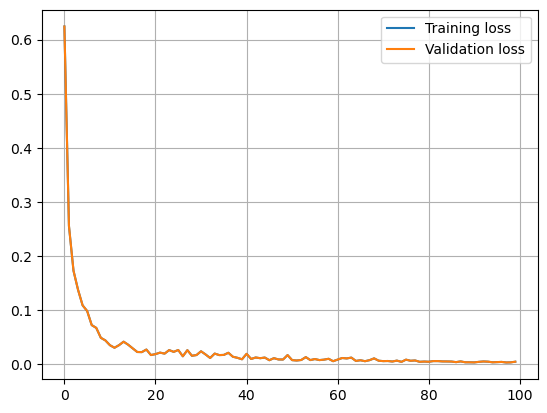

In [35]:
plt.plot(train_loss_list, label='Training loss')
plt.plot(valid_loss_list, label='Validation loss')
plt.legend(loc="best")
plt.grid("on")
plt.show()

### Metrics

Print out appropriate metrics for the task

In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix, fbeta_score, classification_report

# compute test accuracy
with torch.no_grad():
    correct = 0
    total = 0
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)
        outputs = model(X)
        loss = criterion(outputs, y)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
    accuracy = correct / total
    print(f'Accuracy of the network on the {total} test images: {accuracy:.4f}')

Accuracy of the network on the 192 test images: 0.9583


Did you manage to catch them all?